In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load Data

In [2]:
# Load data as pandas df
df = sm.datasets.engel.load_pandas().data.round(2)

# Add flag
df["is_outlier"] = False

# Information
print("Shape of the data:", df.shape)

# Save exogen and response variable
X = df["income"]
y = df["foodexp"]

# Add constant to exogen variables to add intercept in model
X = sm.add_constant(X)

# Save size for population
N_POPULATION = df.shape[0]

# Preview Data
df.head(5)

Shape of the data: (235, 3)


,income,foodexp,is_outlier
0,420.16,255.84,False
1,541.41,310.96,False
2,901.16,485.68,False
3,639.08,403.00,False
4,750.88,495.56,False


# Visualize Population

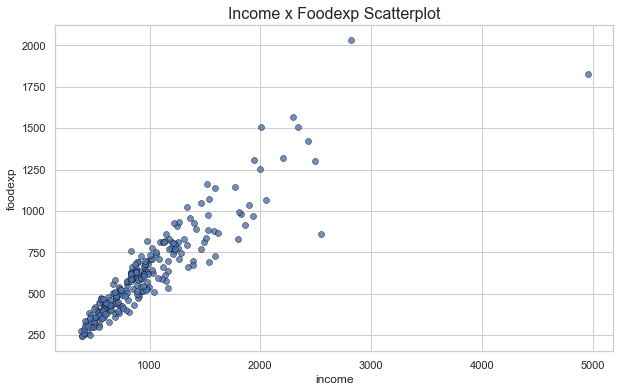

In [3]:
plt.figure(figsize=(10,6))
plt.title("Income x Foodexp Scatterplot", size=16)
sns.scatterplot(data=df, x="income", y="foodexp", edgecolor="black", alpha=0.8)
plt.savefig("figures/population.svg", dpi=256)
plt.show()

## Get estimators from population 

In [4]:
# Instantiate ols model
ols_model_pop = sm.OLS(endog=y, exog=X)

# Train model, i.e. fit estimators
ols_res_pop = ols_model_pop.fit()

# Instantiate LAD model
lad_model_pop = smf.quantreg("foodexp ~ income", df)

# Fit model with q=0.5, i.e. LAD Regression
lad_res_pop = lad_model_pop.fit(q=0.5)

In [5]:
# Get coefficients from population
INTERCEPT_OLS_POP, BETA1_OLS_POP = ols_res_pop.params
INTERCEPT_LAD_POP, BETA1_LAD_POP = lad_res_pop.params

# Get standard errors of population
#INTERCEPT_STE_OLS_POP, BETA1_STE_OLS_POP = ols_res_pop.bse[0], ols_res_pop.bse[1]
#INTERCEPT_STE_LAD_POP, BETA1_STE_LAD_POP = lad_res_pop.bse[0], lad_res_pop.bse[1]

_____
# Simulate

In [6]:
# Master lists containing tuples of each regression iteration
results_ols: list = []
results_lad: list = []
    
def add_outlier_to_df(df, n_outlier) -> pd.DataFrame():
    """
    Function to synthetically add outliers to a given dataframe
    
    :param df Pandas DataFrame to add outlier to
    """
    res: list = []
        
    temp = df.drop(columns="is_outlier")
        
    for i in range(n_outlier):
        outlier = []
        
        for col in temp.columns:
            # Get Q1 and Q3 to get IQR
            q1 = temp[col].quantile(0.25)
            q3 = temp[col].quantile(0.75)
            IQR = q3 - q1

            # Lower and upper bound
            lower_bound = (q1 - 1.5 * IQR)
            upper_bound = (q3 + 1.5 * IQR)

            # Get standard deviation of the current columns
            std = np.std(temp[col])
            
            # Generate random noise in the intervall
            if col == "income":
                outlier.append(np.random.uniform(low=upper_bound + 3*std, high=upper_bound + 4*std))
            else:
                outlier.append(np.random.uniform(low=q1, high=q3))
            
        res.append(tuple(outlier))
        
    # Create df with outlier and append flag to it
    outlier_df = pd.DataFrame(res, columns=temp.columns)
    outlier_df["is_outlier"] = True
    
    # Concate with input df and return
    df_res = pd.concat([df, outlier_df])
    
    return df_res
            
    
def append_data_from_model(res, flag) -> None:
    """
    Appends values from each regression result 'res' to the master list
    
    :param res Result of the regression model
    :param flag Flag which regression is used, e.g. "ols"
    """
    
    # Append paramators to estimators_list
    intercept = res.params[0]
    coefficient = res.params[1]

    # Get standard errors of estimators
    #intercept_ste = res.bse[0]
    #coefficient_ste = res.bse[1]

    # Create row
    row = (intercept, coefficient)#, intercept_ste, coefficient_ste, flag)
    
    # Append data to ols or lad list
    if flag == "ols":
        results_ols.append(row)
    else:
        results_lad.append(row)
    

def simulate(population: pd.DataFrame = df,
             n_sample: int = 100, 
             n_regression: int = 50) -> pd.DataFrame:
    """
    Function to simulate OLS and LAD regression on data that was drawn from the population with replacement
    n_sample times. Allows creating synthetic outlier specified with n_outlier param before fitting.
    
    :param n_sample Number of samples to be drawn with replacement from population
    :param n_regression Number of iterations to perform OLS and LAD model
    """
    
    for i in range(n_regression):
        # Draw sample with replacement
        df_sample = population.sample(n=n_sample, replace=True)

        # Extract vectors
        X = df_sample["income"]
        y = df_sample["foodexp"]

        # Add constant to exogen variables to add intercept in model
        X = sm.add_constant(X)
        
        # Instantiate ols model
        ols_model = sm.OLS(endog=y, exog=X)

        # Train model, i.e. fit estimators
        ols_res = ols_model.fit()
           
        # Instantiate LAD model
        lad_model = smf.quantreg("foodexp ~ income", df_sample)

        # Fit model with q=0.5, i.e. LAD Regression
        lad_res = lad_model.fit(q=0.5)
               
        # Save values of current OLS model to list
        append_data_from_model(ols_res, flag = "ols")
        
        # Save values of current LAD model to list
        append_data_from_model(lad_res, flag = "lad")
        
    # Create df enlisting all values of each iteration
    df_ols = pd.DataFrame(results_ols, columns = ["intercept", "beta_1"])#, "flag"])# "intercept_1_se", "beta_1_se", "flag"])
    df_lad = pd.DataFrame(results_lad, columns = ["intercept", "beta_1"])#, "flag"])# "intercept_1_se", "beta_1_se", "flag"])
        
    return df_ols, df_lad


def plot_results_with_outlier(df_ols, df_lad, df_ols_with_outlier, df_lad_with_outlier):
    """
    Function that compares the intercept, beta_1 with and without outlier
    OLS and LAD as well as OLS and LAD after adding outlier.
    
    First computes the mean and standard deviation of each attribute.
    Then plots a histogram with KDE for comparison.
    
    :param df_ols Dataframe of the OLS results
    :param df_lad Dataframe of the LAD results
    :param df_ols_with_outlier Dataframe of the OLS results with outlier
    :param df_lad_with_outlier Dataframe of the LAD results with outlier  
    """
    
    #df_ols = df_ols.drop(columns="flag")
    #df_lad = df_lad.drop(columns="flag")
    #df_ols_with_outlier = df_ols_with_outlier.drop(columns="is_outlier")
    #df_lad_with_outlier = df_lad_with_outlier.drop(columns="is_outlier")
    
    # Define color list
    COLORS = ["C0", "C3"]
    
    for i, col in enumerate(df_ols.columns):
        ground_truth_ols = 0
        ground_truth_lad = 0
        if col == "intercept":
            ground_truth_ols = INTERCEPT_OLS_POP
            ground_truth_lad = INTERCEPT_LAD_POP
        if col == "beta_1":
            ground_truth_ols = BETA1_OLS_POP
            ground_truth_lad = BETA1_LAD_POP
        if col == "intercept_1_se":
            ground_truth_ols = INTERCEPT_STE_OLS_POP
            ground_truth_lad = INTERCEPT_STE_LAD_POP
        if col == "beta_1_se":
            ground_truth_ols = BETA1_STE_OLS_POP
            ground_truth_lad = BETA1_STE_LAD_POP  
        
        # Compute mean and std
        ols_mean = np.around(np.mean(df_ols[col]), 4)
        ols_std = np.around(np.std(df_ols[col]), 4)
        lad_mean = np.around(np.mean(df_lad[col]), 4)
        lad_std = np.around(np.std(df_lad[col]), 4)
        ols_outlier_mean = np.around(np.mean(df_ols_with_outlier[col]), 4)
        ols_outlier_std = np.around(np.std(df_ols_with_outlier[col]), 4)
        lad_outlier_mean = np.around(np.mean(df_lad_with_outlier[col]), 4)
        lad_outlier_std = np.around(np.std(df_lad_with_outlier[col]), 4)
        
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,9), sharex=True)
        fig.suptitle(f"Histogram of {col} (# Samples = {N} | # Regressions = {N_REGRESSION} | {n_outlier} Outliers ({N_OUTLIER_PERCENT*100}%))", size=18)
        
        sns.histplot(data=df_ols, x=col, ax=ax[0][0], edgecolor="black", color=COLORS[0], kde=True)
        ax[0][0].set_title(f"OLS ($\mu = {ols_mean}, \sigma = {ols_std}$)", size=14)
        ax[0][0].axvline(x=ground_truth_ols, color="g", linestyle = "--", label="Pop. Estimator")
        ax[0][0].legend()
        
        sns.histplot(data=df_lad, x=col, ax=ax[0][1], edgecolor="black", color=COLORS[0], kde=True)
        ax[0][1].set_title(f"LAD ($\mu = {lad_mean}, \sigma = {lad_std}$)", size=14)
        ax[0][1].axvline(x=ground_truth_lad, color="g", linestyle = "--", label="Pop. Estimator")
        ax[0][1].legend()
        
        sns.histplot(data=df_ols_with_outlier, x=col, ax=ax[1][0], edgecolor="black", color=COLORS[1], kde=True)
        ax[1][0].set_title(f"OLS with Outlier ($\mu = {ols_outlier_mean}, \sigma = {ols_outlier_std}$)", size=14)
        ax[1][0].axvline(x=ground_truth_ols, color="g", linestyle = "--", label="Pop. Estimator")
        ax[1][0].legend()
        
        sns.histplot(data=df_lad_with_outlier, x=col, ax=ax[1][1], edgecolor="black", color=COLORS[1], kde=True)
        ax[1][1].set_title(f"LAD with Outlier ($\mu = {lad_outlier_mean}, \sigma = {lad_outlier_std}$)", size=14)
        ax[1][1].axvline(x=ground_truth_lad, color="g", linestyle = "--", label="Pop. Estimator")
        ax[1][1].legend()
        
        plt.tight_layout()
        plt.savefig(f"figures/comparison_{col}.svg", dpi=256)
        plt.show()


## OLS Regression

The following function is the target function of the OLS regression:
$$ \min_\beta \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2 $$

Which can be solved using linear algebra, i.e. compute the derivation, set to 0 and solve for $\beta$:

$$ \hat{\beta} = (X'X)^{-1}X'y $$

## LAD Regression
LAD regression is very similar to OLS regression, but instead of trying to minimize the squared residuals, we minimize the absolute residuals, i.e. the difference between the actual response variable $y$ and our estimated values $\hat{y}$.  

So the objective function is defined as:

$$ \min_\beta \sum_{i=1}^n |y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j| $$

Unlike the OLS solution, we can not solve this analytically. So there exists many approaches.  
The statsmodel.api uses the **Iterative Weighted Least Squares** approach.

_________

## Tune the Parameters

In [7]:
%%capture
############################################################################################
############################### HYPERPARAMS ################################################
N = 100                           # Number of sample to draw with replacement
N_REGRESSION = 1000               # Number of regressions to perform
N_OUTLIER_PERCENT = 0.10          # Percentage of Outliers to create (w.r.t. Pop. size)
############################################################################################

# Number of outliers w.r.t. desired percentage
n_outlier = int(N_POPULATION * N_OUTLIER_PERCENT)

# Call function to get dataframes
df_ols, df_lad = simulate(population = df,
                          n_sample = N,
                          n_regression = N_REGRESSION)

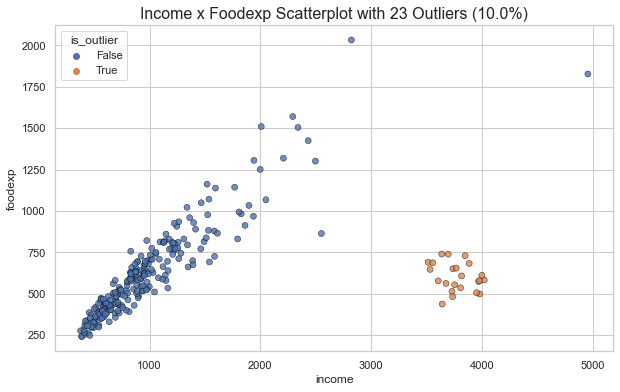

In [8]:
# Create DF with Outlier
df_with_outlier = add_outlier_to_df(df, n_outlier = n_outlier)

# Plot population with Outliers
plt.figure(figsize=(10,6))
plt.title(f"Income x Foodexp Scatterplot with {n_outlier} Outliers ({N_OUTLIER_PERCENT * 100}%)", size=16)
sns.scatterplot(data=df_with_outlier, x="income", y="foodexp", edgecolor="black", alpha=0.8, hue="is_outlier")
plt.savefig("figures/population_w_outlier.svg", dpi=256)
plt.show()

In [9]:
%%capture
# Call function again with outlier
df_ols_outlier, df_lad_outlier = simulate(population = df_with_outlier,
                                          n_sample = N,
                                          n_regression = N_REGRESSION)

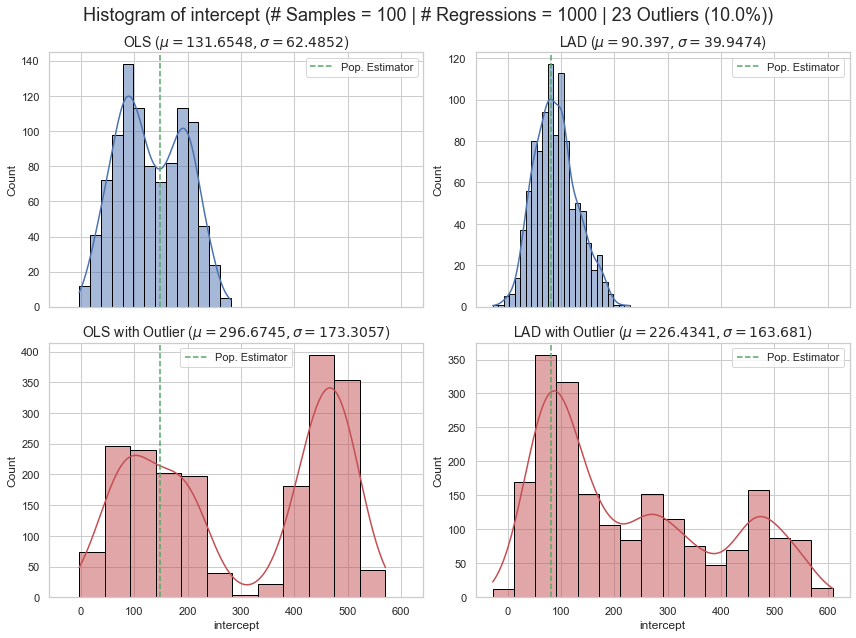

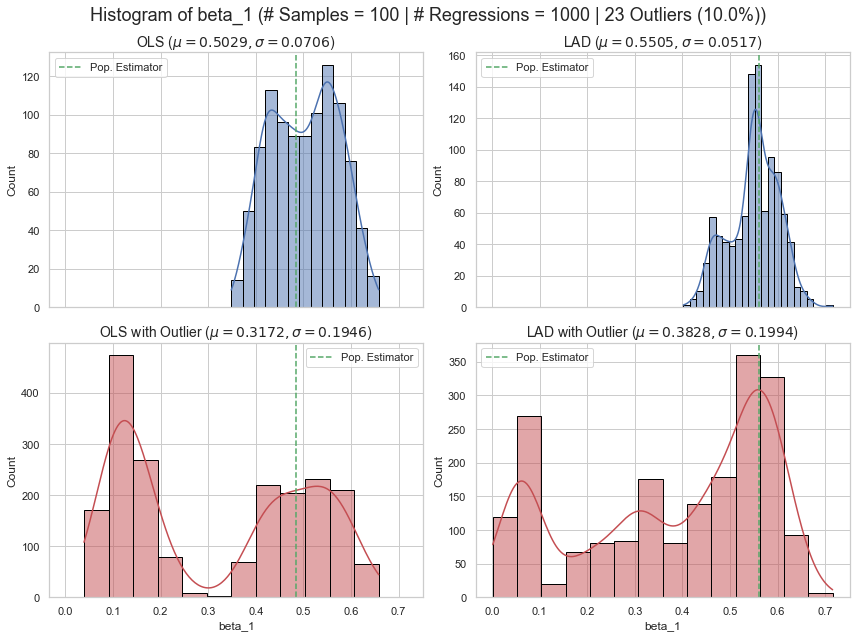

In [10]:
plot_results_with_outlier(df_ols, df_lad, df_ols_outlier, df_lad_outlier)